In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Dataset/train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df = df.dropna()
X = df.drop('label' , axis =1)
y = df['label']
print(X.shape)
print(y.shape)

(18285, 4)
(18285,)


# Data Preprocessing

In [4]:
import nltk 
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sharm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sharm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Making a copy of dataset if things mess up we have a backup

In [5]:
copy = X.copy()
copy.reset_index(inplace = True)

In [7]:
#Removing Stopwords and stemming all the Data
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
data = []
for i in range(0 , len(copy)):
    x = re.sub('[^a-zA-Z]' , ' ' , copy['title'][i])
    x = x.lower()
    x = x.split()
    x = [ps.stem(word) for word in x if not word in stopwords.words('english')]
    x = ' '.join(x)
    data.append(x)

In [10]:
voc_size = 5000
onehot = [one_hot(words , voc_size) for words in data]
onehot;

In [11]:
#Embedding 
sent_lenght = 20
emb = pad_sequences(onehot , padding = 'pre' , maxlen = sent_lenght)
print(emb[0])

[   0    0    0    0    0    0    0    0    0    0  313  645 2615 2930
 2224 3211  234 4436  938 4268]


# Model

In [12]:
vec_feature = 40
model = Sequential()
model.add(Embedding(voc_size , vec_feature , input_length = sent_lenght))
model.add(LSTM(100))
model.add(Dense(1 ,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
len(emb) , y.shape

(18285, (18285,))

In [16]:
import numpy as np
X_final = np.array(emb)
y_final = np.array(y)
print(X_final.shape)
print(y_final.shape)

(18285, 20)
(18285,)


In [17]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X_final , y_final , test_size=0.33 , random_state=42 )

In [20]:
#Model training 
model.fit(X_train , y_train , validation_data=(X_test , y_test) , epochs = 10 , batch_size = 64)

Epoch 1/10
192/192 [==============================] - 8s 41ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.5766 - val_accuracy: 0.9036
Epoch 2/10
192/192 [==============================] - 8s 39ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.6522 - val_accuracy: 0.9041
Epoch 3/10
192/192 [==============================] - 8s 40ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.6235 - val_accuracy: 0.9014
Epoch 4/10
192/192 [==============================] - 8s 40ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.7545 - val_accuracy: 0.9059
Epoch 5/10
192/192 [==============================] - 8s 40ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.7570 - val_accuracy: 0.8996
Epoch 6/10
192/192 [==============================] - 8s 40ms/step - loss: 4.4413e-04 - accuracy: 1.0000 - val_loss: 0.8248 - val_accuracy: 0.9057
Epoch 7/10
192/192 [==============================] - 8s 40ms/step - loss: 1.2203e-04 - accuracy: 1.0000 - val_loss: 0.8590 - val_accuracy

### Predictions and Evaluation

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import precision_score , recall_score , f1_score
y_pred = model.predict_classes(X_test)
#Creating the Confucion Matrix
print(confusion_matrix(y_test , y_pred))

[[3109  310]
 [ 261 2355]]


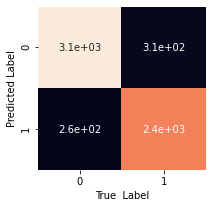

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
def abc(y_test , y_pred):
    fig , ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(confusion_matrix(y_test , y_pred),
                    annot = True,
                    cbar = False)
    plt.xlabel("True  Label")
    plt.ylabel("Predicted Label")
abc(y_test , y_pred)

In [40]:
#Classification Report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3419
           1       0.88      0.90      0.89      2616

    accuracy                           0.91      6035
   macro avg       0.90      0.90      0.90      6035
weighted avg       0.91      0.91      0.91      6035



# Testing model on Test Dataset

In [26]:
df_test = pd.read_csv('Dataset/test.csv')
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [27]:
#Preprocessing Data as done on train dataset
copy_test = df_test.copy()
copy_test.reset_index(inplace = True)

In [29]:
data2 = []
for i in range(0 , len(copy_test)):
    y = re.sub("[^a-zA-Z]" , " " , str(copy_test['title'][i]))
    y = y.lower()
    y = y.split()
    y = [ps.stem(word) for word in y if not word in stopwords.words('english')]
    y = ' '.join(y)
    data2.append(y)

In [31]:
#Applying one hot on the data
one = [one_hot(words , voc_size) for words in data2]
one;

In [32]:
#Embedding Layer
emb_2 = pad_sequences(one , padding = 'pre' , maxlen = sent_lenght)
print(emb_2[0])

[   0    0    0    0    0    0    0    0    0 3250 4666 2486 3895 3368
  930 1992    2 3487  266 3712]


In [33]:
len(emb_2)

5200

In [36]:
test_df = np.array(emb_2)

In [41]:
test_pred = model.predict_classes(test_df)

C:\Users\sharm\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
test_pred = pd.DataFrame(test_pred , columns=['Predictions'])